In [1]:

import os
import sys
import io
from PIL import Image
import warnings
import pytesseract
import cv2
from datasets import DatasetDict
import time
import numpy as np


# zeige keine Warnungen an
warnings.filterwarnings("ignore")

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from src.utils import rotate_image, pil_to_cv, from_cv_to_pil
from src.ocr_pipeline import OCRPreprocessor, OCRPostProcessor

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Laden des Datensatzes
dataset = DatasetDict.load_from_disk("../data/interim_rgb")

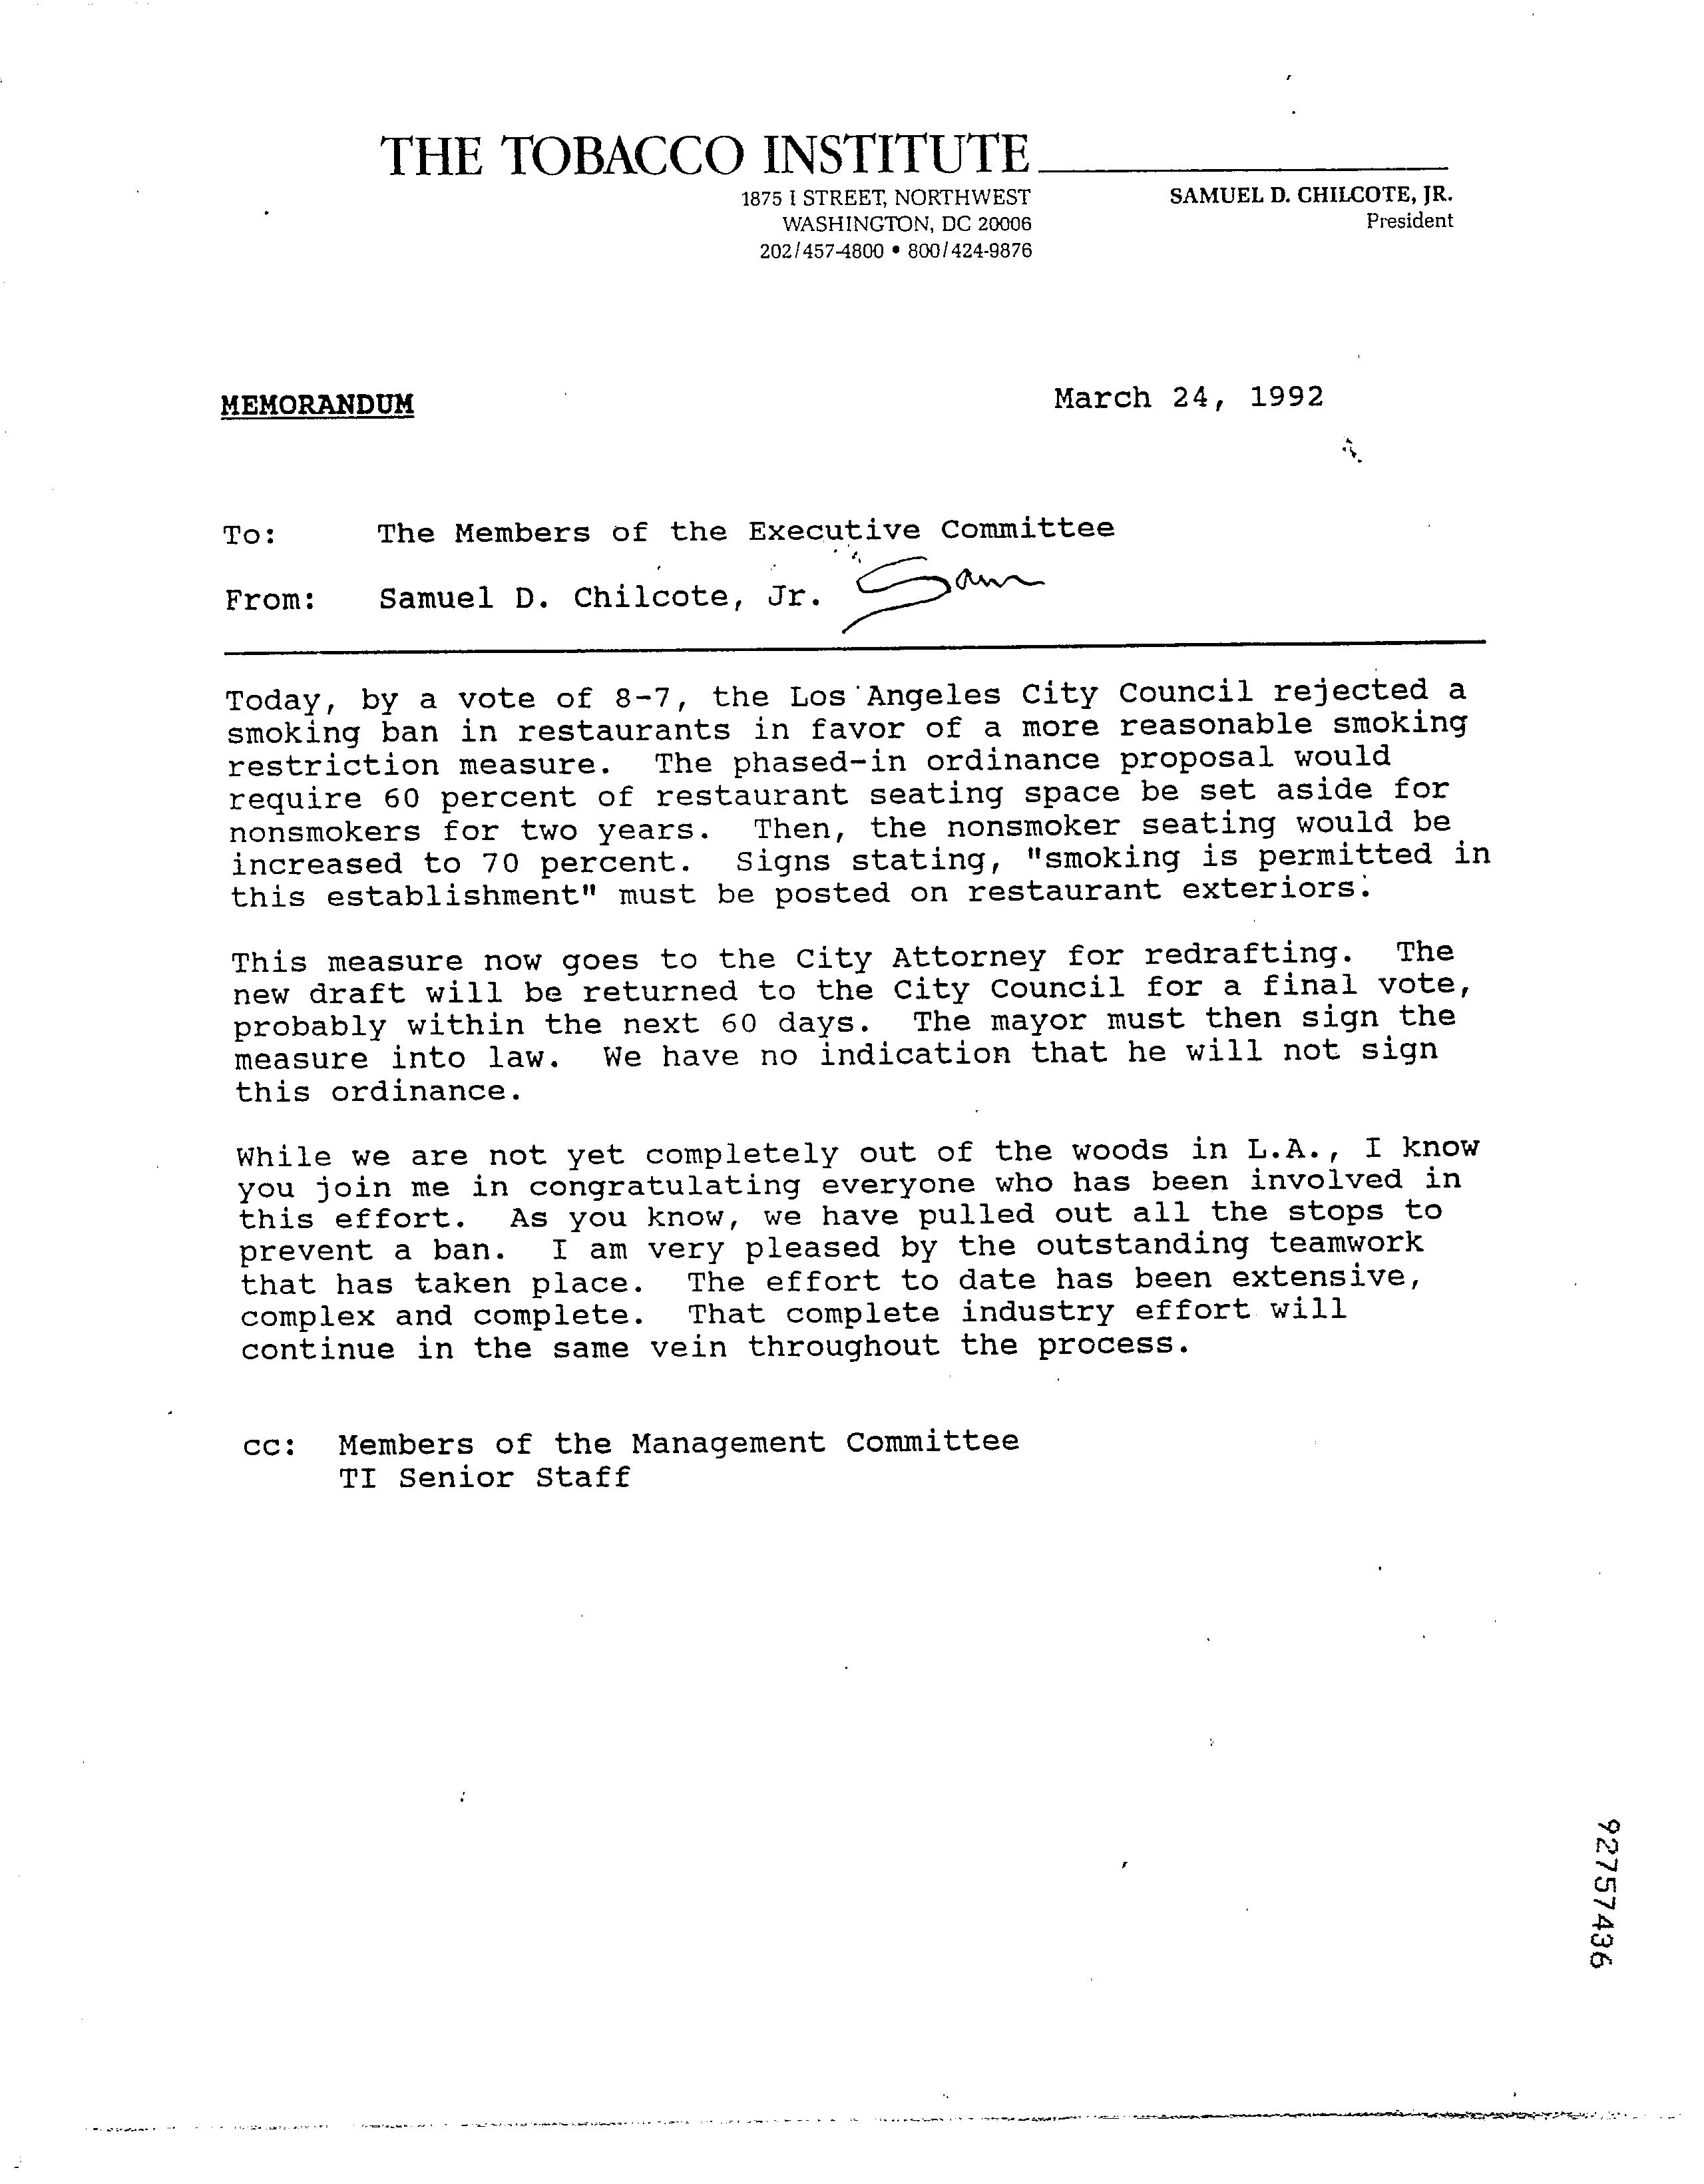

In [3]:
image = dataset["train"][0]["image"]
image

CPU times: user 1.14 s, sys: 503 ms, total: 1.64 s
Wall time: 1.61 s


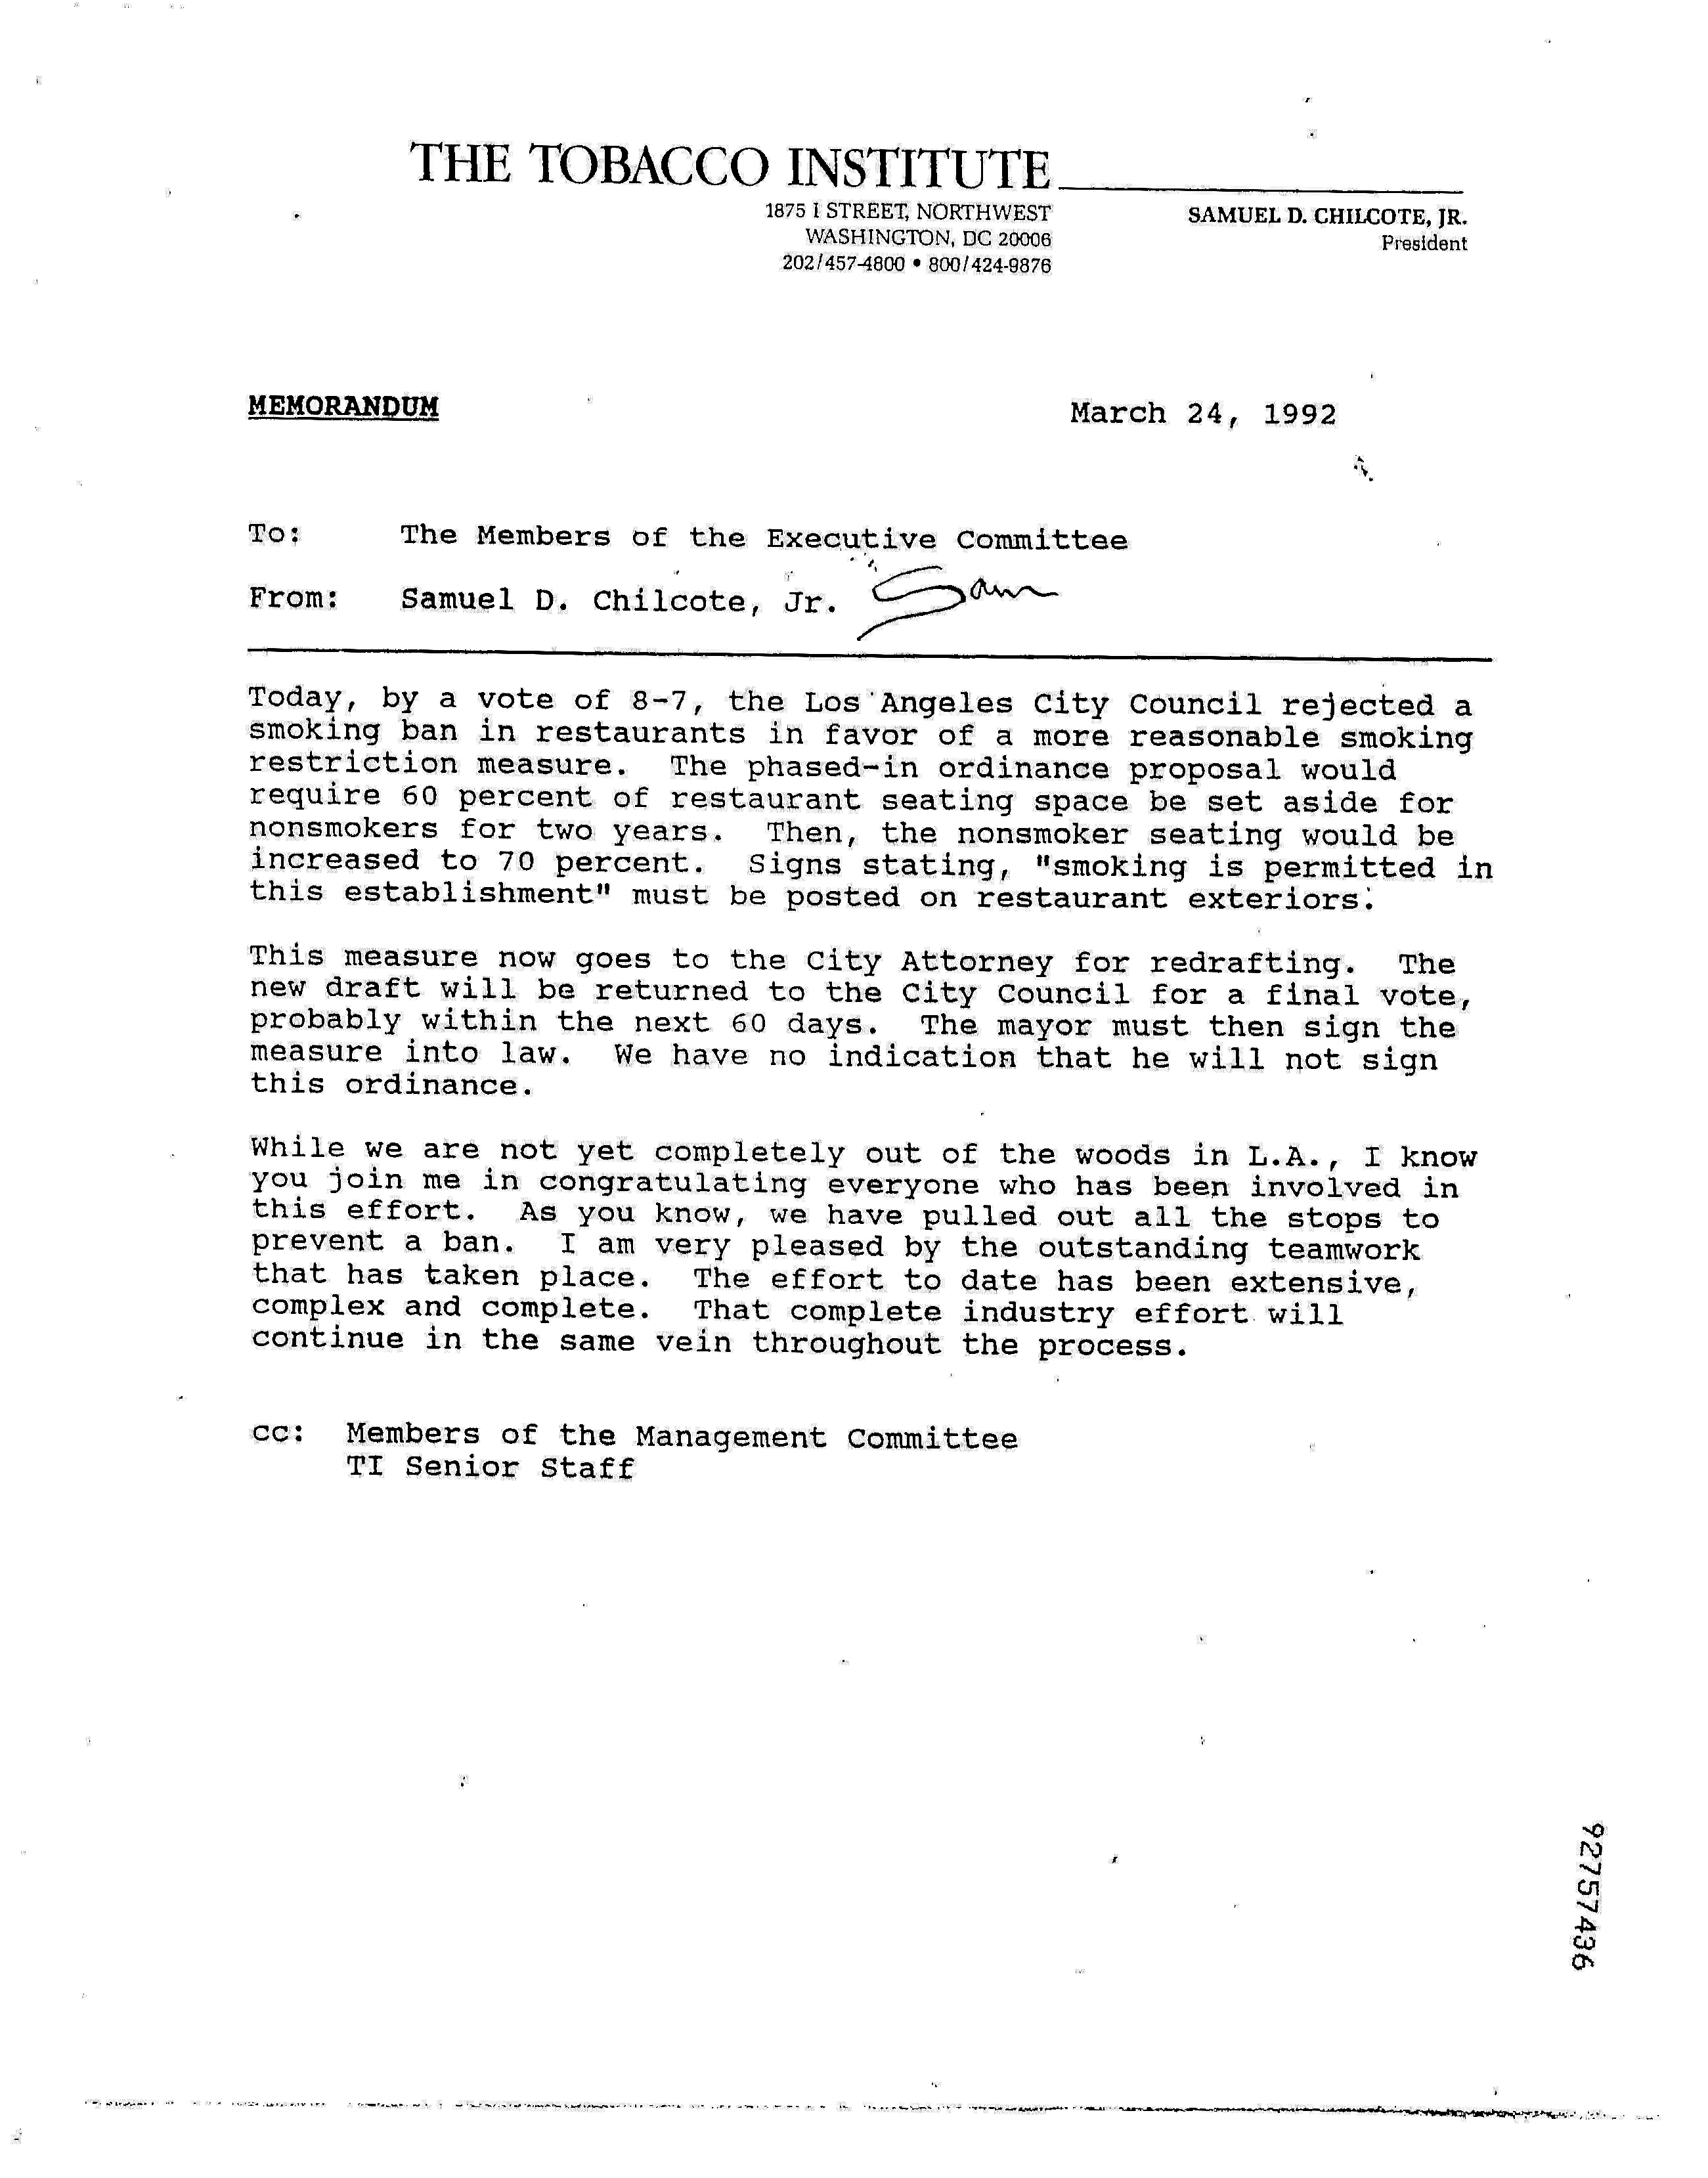

In [16]:
%%time
# Anwenden der OCR Vorverarbeitung
preprocessor = OCRPreprocessor(image)
preprocessor.cropping(buffer_size=10)
preprocessor.contrast_stretching()
#preprocessor.power_law_transform(gamma=2)
preprocessor.to_gray()
preprocessor.correct_skew()
preprocessor.sharpen(kernel_type="laplace_standard")
preprocessor.opening(kernel=(1,1), iterations=2)
preprocessor.power_law_transform(gamma=2)
processed_image = preprocessor.get_image()
processed_image

In [17]:
%%time
pytesseract_output = pytesseract.image_to_string(processed_image)
pytesseract_output

CPU times: user 289 ms, sys: 16.1 ms, total: 305 ms
Wall time: 2.2 s


'THE TOBACCO INSTITUTE\n\n1875 1 STREET, NORTHWEST SAMUEL D. CHILCOTE, JR.\nWASHINGTON, DC 20006 President\n202/457-4800 * 800/424-9876\nMEMORANDUM , March 24, 1992\n‘.\nTo: The Members of the Executive Committee\n\n4\n\nFrom: Samuel D. Chilcote, Jr. =\n\nToday, by a vote of 8-7, the Los Angeles City Council rejected a\nsmoking ban in restaurants in favor of a more reasonable smoking\nrestriction measure. The phased-in ordinance proposal would\nrequire 60 percent of restaurant seating space be set aside for\nnonsmokers for two years. Then, the nonsmoker seating would be\nincreased to 70 percent. Signs stating, "smoking is permitted in\nthis establishment" must be posted on restaurant exteriors;\n\nThis measure now goes to the city Attorney for redrafting. The\nnew draft will be returned to the City Council for a final vote,\nprobably within the next 60 days. The mayor must then sign the\nmeasure into law. We have no indication that he will not sign\nthis ordinance.\n\nWhile we are not 

In [18]:
%%time
if pytesseract_output.strip():  # Prüft, ob `ocr_output` nicht leer ist
    postprocessor = OCRPostProcessor(pytesseract_output)
    # Anwenden verschiedener Methoden
    postprocessor.identify_language()
    postprocessor.remove_special_characters()
    postprocessor.lowercase()
    postprocessor.remove_stopwords()
    postprocessor.remove_extra_spaces()
            
    # Aufbereiteten OCR-Output extrahieren
    ocr_output = postprocessor.get_text()
else: ocr_output = "no text found with ocr!"

ocr_output

CPU times: user 1.18 s, sys: 45 ms, total: 1.23 s
Wall time: 535 ms


'tobacco institute 1875 1 street northwest samuel chilcote jr washington dc 20006 president 202 457 4800 800 424 9876 memorandum march 24 1992 members executive committee 4 samuel chilcote jr today vote 8 7 los angeles city council rejected smoking ban restaurants favor reasonable smoking restriction measure phased ordinance proposal would require 60 percent restaurant seating space set aside nonsmokers two years nonsmoker seating would increased 70 percent signs stating smoking permitted establishment must posted restaurant exteriors measure goes city attorney redrafting new draft returned city council final vote probably within next 60 days mayor must sign measure law indication sign ordinance yet completely woods l know join congratulating everyone involved effort know pulled stops prevent ban pleased outstanding teamwork taken place effort date extensive complex complete complete industry effort continue vein throughout process cc members management committee ti senior staff fevlsl